# Power spectrum

With this code we compute a power spectrum as function of $\phi_1$ and s. The aim is to reproduce the results of Ibata et al. 2019 (arXiv: https://arxiv.org/pdf/2002.01488) to later apply the code on our own data.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import math
import random
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.signal import csd
from sympy import *
from sympy import symbols
from sympy import integrate
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, Image
import io
from scipy.signal import welch

import spectrum

## As a function of $\phi_1$ 

### Import data 

In [3]:
# Import data from the Ibata paper for comparison
data = pd.read_csv('../data/ibata/Ibata_Hist_Gaia.csv')
count = data['y'].values
phi = data['x'].values

# Import the fitted data
datafit = pd.read_csv('../data/ibata/Ibata Gaia Fit.csv')
xfit = datafit['x'].values
yfit = datafit['y'].values

# Calculate the counts using the functions given in the Ibata paper
fit_div = spectrum.ibata_fitting(phi)
fit_not_div = spectrum.ibata_fitting_modified(phi)

# print(phi)

### Plot density contrast

We plot a histogram of the density contrast.

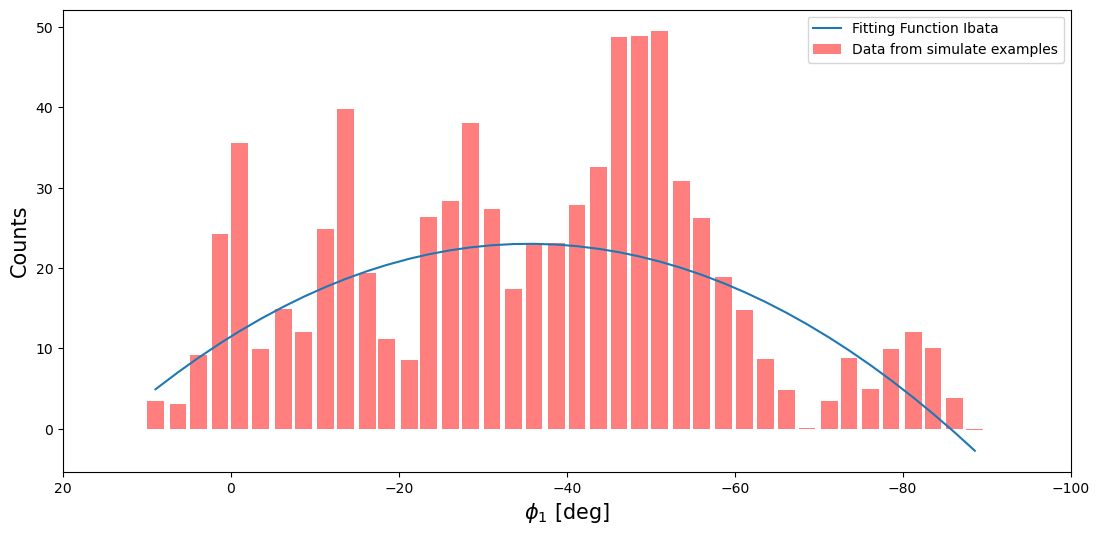

In [4]:
plt.figure(figsize=(13,6))
plt.bar(phi, count,width=2, color='r',alpha=0.5, label = 'Data from simulate examples')
# plt.plot(phi,quadratic_fit,label='Fitting Function')
plt.plot(phi,fit_not_div,label='Fitting Function Ibata')
plt.xlim([20,-100])
plt.ylabel('Counts',size=15)
plt.xlabel(r'$\phi_1$ [deg]',size=15)
plt.legend()
plt.savefig('../results/density_contrast_phi1/density_reference_phi1.pdf')

### Calculate power spectrum

In [5]:
# Calculate density contrast

dens_fit = count/fit_not_div 

For the calculation of the power spectrum we use the CSD-algorithm by SciPy (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) and set:

- *fs* = sympling frequency (1 divided by bin-size)
- *nperseg* = length of each segment (len(phi) = 40)

In [6]:
f_fit, pxx_fit = csd(dens_fit,dens_fit,fs=1/2.5,scaling='spectrum',nperseg=40)

### Plot power spectrum

In [7]:
# print(f_fit)

In [8]:
print(pxx_fit)

[4.49283454e-02 8.51834454e-02 1.30375235e-01 1.14080156e-01
 8.38748888e-02 3.58730332e-02 5.79980979e-02 3.81669869e-03
 1.48376792e-02 2.07069344e-02 9.79422271e-04 2.01713111e-03
 4.22606217e-03 4.87962351e-03 1.55740697e-03 4.22690748e-04
 5.01914167e-04 3.25883775e-03 1.10807576e-02 6.03497257e-03
 6.27479296e-06]


In [9]:
f_fit_mod = f_fit[1:]
pxx_fit_mod = pxx_fit[1:]

In [10]:
# Freq
freq_phi = 1/f_fit
freq_phi_mod = 1/f_fit_mod
print(freq_phi)


[         inf 100.          50.          33.33333333  25.
  20.          16.66666667  14.28571429  12.5         11.11111111
  10.           9.09090909   8.33333333   7.69230769   7.14285714
   6.66666667   6.25         5.88235294   5.55555556   5.26315789
   5.        ]


/tmp/ipykernel_4474/1025945185.py:2: RuntimeWarning: divide by zero encountered in divide
  freq_phi = 1/f_fit


In [11]:
print(freq_phi[1])

100.0


findfont: Font family 'Baskerville Old Face' not found.
findfont: Font family ['Baskerville Old Face'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Baskerville Old Face' not found.
findfont: Font family 'Baskerville Old Face' not found.


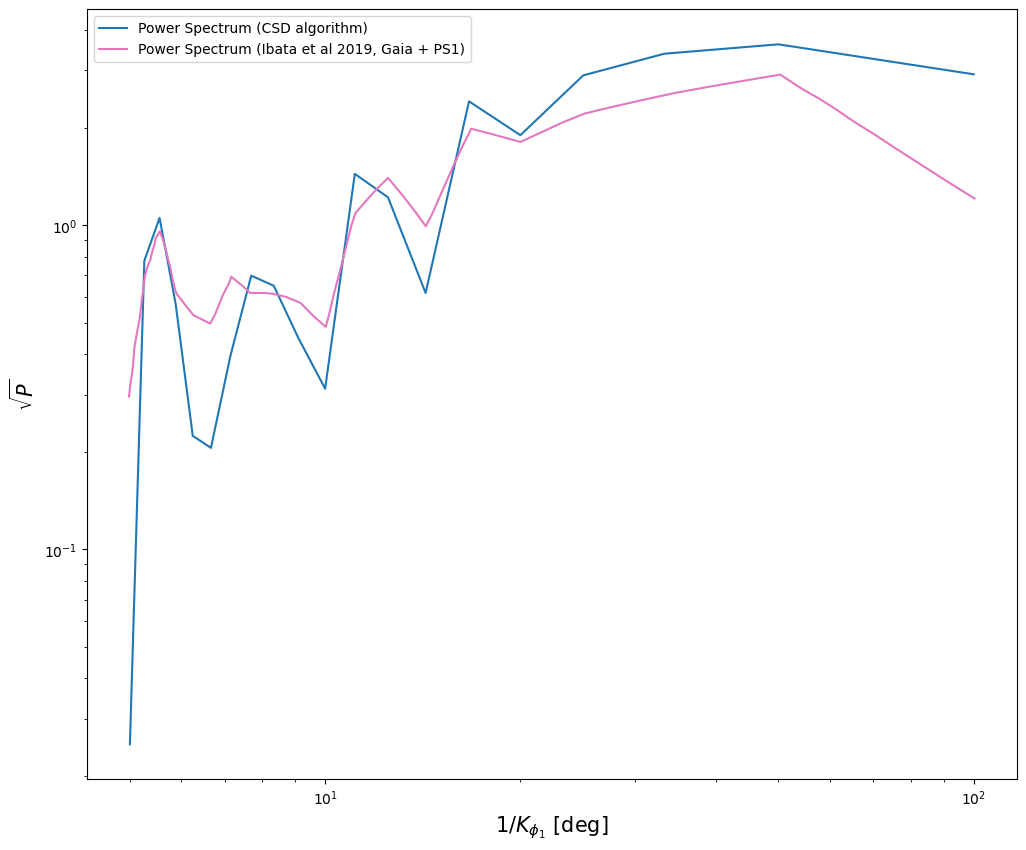

In [12]:
# Plot power spectrum 
### Plot 1/frequency and take the square root of the power * (phi[-1] - phi[0] = 97.5)
plt.figure(figsize=(12,10))
# plt.loglog(freq_phi_mod, 1*np.sqrt(freq_phi_mod[1]*np.array(pxx_fit_mod)), color='r', label='Power Spectrum (mod.)')
plt.loglog(freq_phi, 1*np.sqrt(freq_phi[1]*np.array(pxx_fit)),label='Power Spectrum (CSD algorithm)')

# plt.loglog((1) / f_fit, 1*np.sqrt((97.58804695)*np.array(pxx_fit)),label='Power Spectrum')
# print(1/f_fit_not_div)

# plt.loglog(1/f_fit, np.sqrt(pxx_fit), color='green', label='Power Spectrum')  # Angepasste Darstellung

# Plot the power spectrum from the Ibata paper to compare
data = pd.read_csv('../data/ibata/Ibata_PS_Gaia.csv')
freq = data['f'].values
power = data['p'].values
plt.loglog(freq, power, color='tab:pink', label='Power Spectrum (Ibata et al 2019, Gaia + PS1)')
plt.ylabel(r'$\sqrt{P}$',size=15)
plt.xlabel(r'$1/K_{\phi_1}$ [deg]',size=15, fontname='Baskerville Old Face')
plt.legend()
# plt.title('Power Spectrum', fontname='Garamond')

# Save and show
plt.savefig('../results/power_spectrum_phi1/reference_phi1.pdf')
plt.show()

## As a function of s 

### Import data

In [13]:
# Import the power spectrum from the Ibata paper for comparison
data = pd.read_csv('../data/ibata/ibata_gaia_ps_s.csv')
count_ibata = data['y'].values
s_ibata = data['x'].values

# Upper bounds
data = pd.read_csv('../data/ibata/ibata_upper.csv')
count_ibata_upper = data['y'].values
s_ibata_upper = data['x'].values

# Lower bounds
data = pd.read_csv('../data/ibata/ibata_lower.csv')
count_ibata_lower = data['y'].values
s_ibata_lower = data['x'].values

# print(count_ibata)
# print(s_ibata)
# print(count_ibata_upper)
# print(s_ibata_upper)
# print(count_ibata_lower)
# print(s_ibata_lower)

### Create random values

We take the number of counts of every single bin of $\phi_1$ and create an identical number of random values of $\phi_1$ within the range of each bin. These values are stored in a new array called random_phi.

In [14]:
binning = phi
bin_size = 2.5
bin_number = 40

In [15]:
# Generate random values

random_phi = spectrum.random_values(count, binning, bin_size)
# print(random_phi)

### Perform calculation from $\phi_1$ to s

In [16]:
s = spectrum.perform_integration(random_phi)

### Binning for s

In [17]:
# Calculate bin size of s
# bin_size_s = spectrum.calculate_bin_size_array(s, bin_number)

# Print bin size
# print(bin_size_s)

In [18]:
# Calculate bin size from given bounds (Ibata's binning: min = -10.5, max = 1.5, number = 40)

binning_lower_limit = -10.5
binning_upper_limit = 1.5

bin_size_s = spectrum.calculate_bin_size_bounds(binning_lower_limit, binning_upper_limit, bin_number)

In [19]:
# Create bins for s (adjust minimum_s, if bounds manually chosen)

# minimum_s = min(s)
# minimum_s = binning_lower_limit
# binning_s = spectrum.create_binning(minimum_s, bin_size_s, bin_number)

# print(binning_s)
# print(len(binning_s))

In [20]:
# Calculate bounds of the bins
# binning_s_min, binning_s_max = spectrum.binning_bounds(binning_s, bin_size_s)
# print(binning_s_min), print(binning_s_max)

In [21]:
# Assign the values to binning_s

# counts_s = spectrum.bin_data(s, binning_s_min, binning_s_max, bin_number)
# print(counts_s)

In [22]:
counts_s, binning_s = spectrum.binning(s, bin_number, binning_lower_limit, binning_upper_limit)

### Calculate a fitting function

In [23]:
# Set the error
x = np.array(binning_s)
y = np.array(counts_s)
x_err = np.full_like(x, 1.0)  # Uncertainty for x
y_err = np.sqrt(y) # Uncertainty for y
# x_err = 1.0
# y_err = 1.0

In [24]:
# Import fitting function

params, quadratic_fit = spectrum.quadratic_function(x, y, x_err, y_err)

In [25]:
# Plot
# plt.scatter(x, y, label='Daten')
# plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', label='Daten mit Fehlerbalken')
# plt.plot(x, quadratic_fit, color='red', label='Polynomialer Fit')
# plt.xlabel('s [kpc]')
# plt.ylabel('Counts')
# plt.legend()
# plt.show()

### Plot histogram

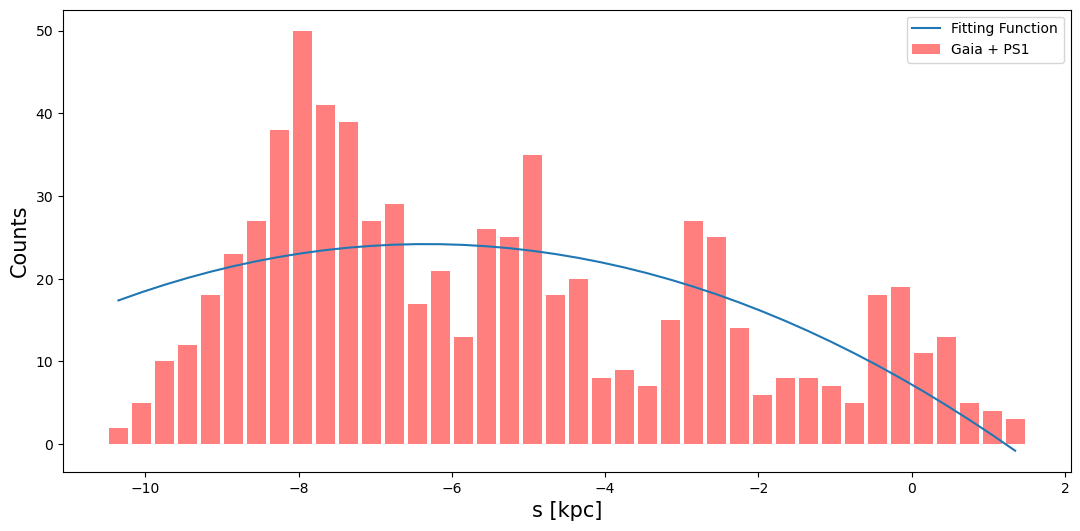

In [26]:
plt.figure(figsize=(13,6))
plt.plot(binning_s, quadratic_fit, label='Fitting Function', zorder=2)
plt.bar(binning_s, counts_s, width=0.25,color='r',alpha=0.5,label = 'Gaia + PS1',zorder=1)
# plt.plot(bins_s_ibata, quadratic_fit, label='Fitting Function', zorder=2)
# plt.bar(bins_s_ibata, counts_s_ibata, width=0.27,color='r',alpha=0.5,label = 'Gaia + PS1',zorder=1)
# plt.xlim([20,-100])
plt.ylabel('Counts',size=15)
plt.xlabel('s [kpc]',size=15)
plt.legend()
plt.savefig('../results/density_contrast_s/density_reference_s.pdf')

### Calculate power spectrum with csd

We calculate the power spectrum with the CSD algorithm by SciPy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) and define:

- *fs* = sampling frequency (set to 1/bin-size ~ 2.5)
- *nperseg* = length of each segment (set to len(phi) = 40)


In [27]:
# Calculate density contrast

dens_fit_s = counts_s/quadratic_fit

In [28]:
print(dens_fit_s)

[ 0.1150715   0.27231024  0.51904459  0.59717028  0.86342446  1.06859867
  1.22041308  1.67787874  2.16492608  1.74712268  1.64122897  1.12584197
  1.20205917  0.70270203  0.86837001  0.53946398  1.08620295  1.05489499
  1.49666455  0.7827628   0.8877267   0.36384662  0.42117159  0.33858159
  0.75362293  1.41679725  1.37861614  0.81703959  0.37360402  0.53661087
  0.58476002  0.56555988  0.45465908  1.88654871  2.37231336  1.71855308
  2.7564257   1.69169365  3.57516632 -3.77779602]


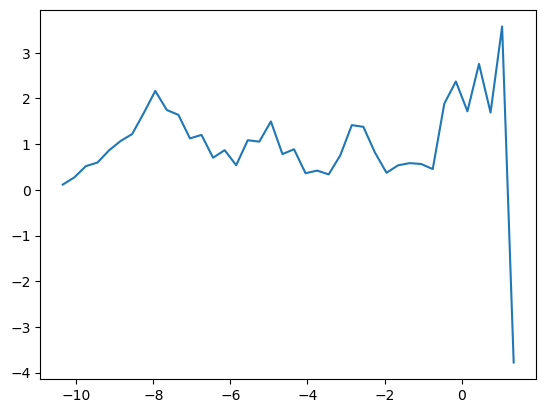

In [29]:
plt.plot(binning_s, dens_fit_s)

In [30]:
print(bin_size_s)

0.3


In [31]:
# Calculate the power spectrum 

f_fit, pxx_fit = csd(dens_fit_s,dens_fit_s,fs=1/bin_size_s,scaling='spectrum',nperseg=bin_number)

# f_fit_err, pxx_fit_err = csd(dens_fit_s_err,dens_fit_s_err, fs=1/0.4,scaling='spectrum',nperseg=40)
# pxx_fit_adj = (180/(np.pi))*pxx_fit
# I'm plotting 1/frequency and I'm taking the square root of the power * s[-1] - s[0] 
# which in this case was 16

In [32]:
# Calculate power
freq = 1/f_fit
# print(power)

/tmp/ipykernel_4474/454648802.py:2: RuntimeWarning: divide by zero encountered in divide
  freq = 1/f_fit


### Welch algorithm for comparison

In [33]:
freq_w, power_welch = welch(dens_fit_s, fs=1/bin_size_s, scaling = 'spectrum', nperseg=bin_number)

In [34]:
freq_welch = 1/freq_w

/tmp/ipykernel_4474/4251512374.py:1: RuntimeWarning: divide by zero encountered in divide
  freq_welch = 1/freq_w


### Plot power spectrum

/tmp/ipykernel_4474/2668400089.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,10])


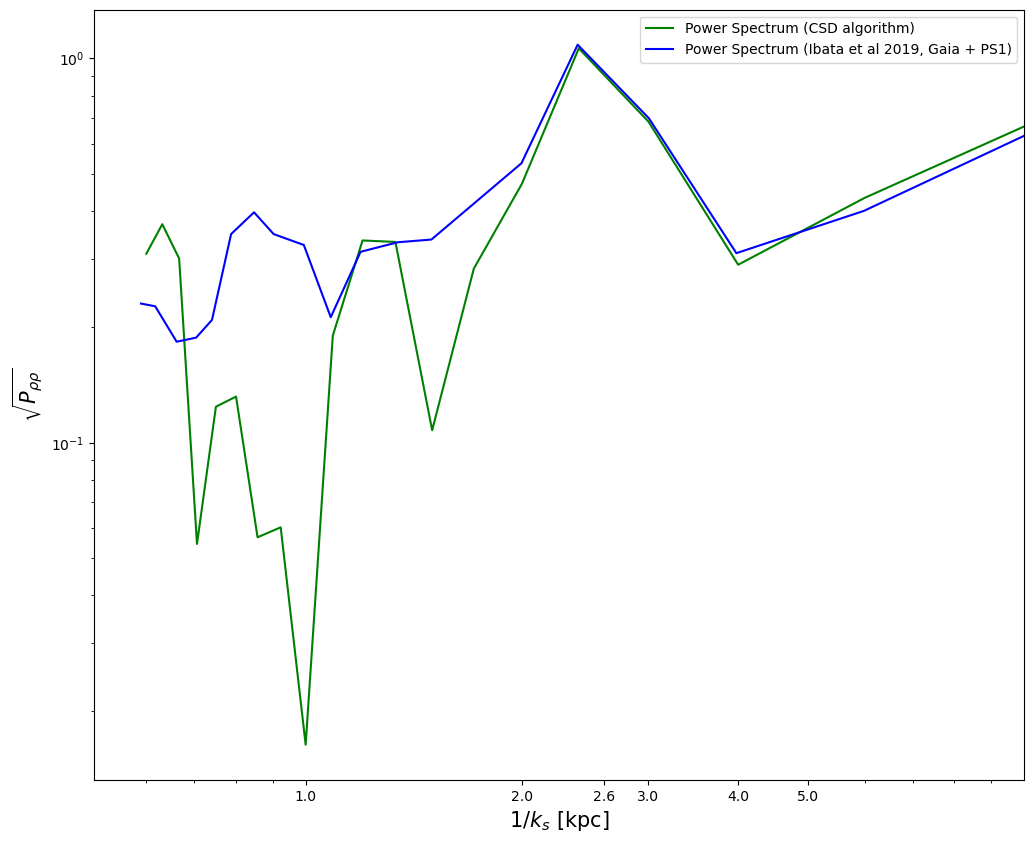

In [35]:
# Plot
plt.figure(figsize=(12,10))
plt.loglog(freq, 1*np.sqrt(freq[1]*np.array(pxx_fit)), color='green', label='Power Spectrum (CSD algorithm)') # adjusted
# plt.loglog((1) / f_fit_err, 1*np.sqrt(16*np.array(pxx_fit_err)), color='red', label='Power Spectrum (Gaia + PS1, y-error adjusted)') # adjusted
plt.plot(s_ibata, count_ibata, color='blue', label='Power Spectrum (Ibata et al 2019, Gaia + PS1)')
# plt.plot(s_ibata_upper, count_ibata_upper, linestyle='--', color='violet', label='Upper limit from Ibata paper')
# plt.plot(s_ibata_lower, count_ibata_lower, color='blue', linestyle='--', label='Lower limit from Ibata paper')
plt.ylabel(r'$\sqrt{P_{\rho\rho}}$',size=15)
plt.xlabel(r'$1/k_{s}$ [kpc]',size=15)
plt.xlim([0,10])
# plt.title('Power Spectrum')

# Scipy.signal.welch for comparison
# plt.loglog(freq_welch, 1*np.sqrt(freq_welch[1]*np.array(power_welch)), linestyle='--', color='red', label='Power Spectrum (scipy.signal.welch algorithm)')
plt.legend()

ax = plt.gca()
# ax.axvline(x=2.6, color='r', linestyle='--', linewidth=2)  # Linie bei x=2.6 einfügen
ax.set_xticks([1, 2, 2.6, 3, 4, 5])
ax.xaxis.set_major_formatter(ScalarFormatter())

# Save and show
plt.savefig('../results/power_spectrum_s/reference_s.pdf')
plt.show()